### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [29]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [31]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    ###<your code>###
    contexts = corpus[window_size:-window_size]
    targets = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([4, 0, 6, 7, 1, 2]),
 array([[3, 0],
        [4, 6],
        [0, 7],
        [6, 1],
        [7, 2],
        [1, 5]]))

In [32]:
# transform contexts and targets to one-hot encoding
### <your code> ###
contexts = convert_one_hot(contexts,len(word2idx))
targets = convert_one_hot(targets,len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]]),
 array([[[0, 0, 0, 1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]]]))

In [33]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [34]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 17%|█████████████                                                                | 170/1000 [00:00<00:00, 1478.76it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.158890702827621
Epoch: 2, Iteration: 1/2, Loss: 4.158911151381153
Epoch: 3, Iteration: 1/2, Loss: 4.159017918135207
Epoch: 4, Iteration: 1/2, Loss: 4.158969434211409
Epoch: 5, Iteration: 1/2, Loss: 4.158751373785917
Epoch: 6, Iteration: 1/2, Loss: 4.158744380149681
Epoch: 7, Iteration: 1/2, Loss: 4.158708077506387
Epoch: 8, Iteration: 1/2, Loss: 4.158741885343449
Epoch: 9, Iteration: 1/2, Loss: 4.158641655168464
Epoch: 10, Iteration: 1/2, Loss: 4.158583298551681
Epoch: 11, Iteration: 1/2, Loss: 4.158538082497183
Epoch: 12, Iteration: 1/2, Loss: 4.1586065032474515
Epoch: 13, Iteration: 1/2, Loss: 4.1582489730799175
Epoch: 14, Iteration: 1/2, Loss: 4.158461442858474
Epoch: 15, Iteration: 1/2, Loss: 4.158097338886107
Epoch: 16, Iteration: 1/2, Loss: 4.158237600379984
Epoch: 17, Iteration: 1/2, Loss: 4.1583031487608455
Epoch: 18, Iteration: 1/2, Loss: 4.157826845000677
Epoch: 19, Iteration: 1/2, Loss: 4.15789944514561
Epoch: 20, Iteration: 1/2, Loss: 4.157

 50%|██████████████████████████████████████                                       | 495/1000 [00:00<00:00, 1500.90it/s]


Epoch: 275, Iteration: 1/2, Loss: 1.4237717721463747
Epoch: 276, Iteration: 1/2, Loss: 1.4197560160921736
Epoch: 277, Iteration: 1/2, Loss: 1.4271794663335637
Epoch: 278, Iteration: 1/2, Loss: 1.4193292399604198
Epoch: 279, Iteration: 1/2, Loss: 1.4196986539685965
Epoch: 280, Iteration: 1/2, Loss: 1.4237639806447993
Epoch: 281, Iteration: 1/2, Loss: 1.4204634430578995
Epoch: 282, Iteration: 1/2, Loss: 1.423391147075586
Epoch: 283, Iteration: 1/2, Loss: 1.4205255281666185
Epoch: 284, Iteration: 1/2, Loss: 1.4161174751462138
Epoch: 285, Iteration: 1/2, Loss: 1.4218965456663164
Epoch: 286, Iteration: 1/2, Loss: 1.4220296626919944
Epoch: 287, Iteration: 1/2, Loss: 1.4193263157560048
Epoch: 288, Iteration: 1/2, Loss: 1.4192882314516888
Epoch: 289, Iteration: 1/2, Loss: 1.4165022761533526
Epoch: 290, Iteration: 1/2, Loss: 1.4191471666755042
Epoch: 291, Iteration: 1/2, Loss: 1.4161843622249268
Epoch: 292, Iteration: 1/2, Loss: 1.4199119612226943
Epoch: 293, Iteration: 1/2, Loss: 1.4186408532

 83%|███████████████████████████████████████████████████████████████▋             | 827/1000 [00:00<00:00, 1518.06it/s]


Epoch: 564, Iteration: 1/2, Loss: 1.3951559541566678
Epoch: 565, Iteration: 1/2, Loss: 1.395842648047274
Epoch: 566, Iteration: 1/2, Loss: 1.3946871863517707
Epoch: 567, Iteration: 1/2, Loss: 1.3957786477924172
Epoch: 568, Iteration: 1/2, Loss: 1.3946305196677964
Epoch: 569, Iteration: 1/2, Loss: 1.3953180293060488
Epoch: 570, Iteration: 1/2, Loss: 1.3950613960096017
Epoch: 571, Iteration: 1/2, Loss: 1.3950702211727148
Epoch: 572, Iteration: 1/2, Loss: 1.395649258636757
Epoch: 573, Iteration: 1/2, Loss: 1.3950658458446452
Epoch: 574, Iteration: 1/2, Loss: 1.3950193993322764
Epoch: 575, Iteration: 1/2, Loss: 1.3945309322338675
Epoch: 576, Iteration: 1/2, Loss: 1.3945587476847967
Epoch: 577, Iteration: 1/2, Loss: 1.3954700007163163
Epoch: 578, Iteration: 1/2, Loss: 1.3948229762565667
Epoch: 579, Iteration: 1/2, Loss: 1.394904034797668
Epoch: 580, Iteration: 1/2, Loss: 1.3949432888523623
Epoch: 581, Iteration: 1/2, Loss: 1.394965386291193
Epoch: 582, Iteration: 1/2, Loss: 1.3947440782089

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1518.08it/s]


Epoch: 859, Iteration: 1/2, Loss: 1.3912300682039
Epoch: 860, Iteration: 1/2, Loss: 1.390941202032143
Epoch: 861, Iteration: 1/2, Loss: 1.3906466129615138
Epoch: 862, Iteration: 1/2, Loss: 1.3909320100683895
Epoch: 863, Iteration: 1/2, Loss: 1.3909318275238463
Epoch: 864, Iteration: 1/2, Loss: 1.3907116064680658
Epoch: 865, Iteration: 1/2, Loss: 1.390895405567482
Epoch: 866, Iteration: 1/2, Loss: 1.3911053489725078
Epoch: 867, Iteration: 1/2, Loss: 1.3909296058333664
Epoch: 868, Iteration: 1/2, Loss: 1.3906225897270073
Epoch: 869, Iteration: 1/2, Loss: 1.3908716163720862
Epoch: 870, Iteration: 1/2, Loss: 1.3911163014915688
Epoch: 871, Iteration: 1/2, Loss: 1.3908609983709879
Epoch: 872, Iteration: 1/2, Loss: 1.3910486031589073
Epoch: 873, Iteration: 1/2, Loss: 1.3906305789072113
Epoch: 874, Iteration: 1/2, Loss: 1.390780114214694
Epoch: 875, Iteration: 1/2, Loss: 1.3911026610317123
Epoch: 876, Iteration: 1/2, Loss: 1.3908159022110957
Epoch: 877, Iteration: 1/2, Loss: 1.390780178170163

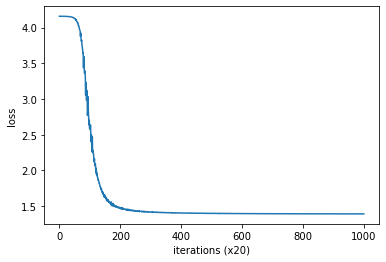

In [35]:
trainer.plot()

In [36]:
# check skip-gram results
### <your code> ###
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

studying [ 2.502647    0.8435674  -0.5512602   0.9125174   0.37532443]
processing [-0.25741574  0.33540925 -2.3591557  -1.5930763   0.23177211]
now [-0.86639297 -0.49735793  2.2491784  -0.8152124   1.2367994 ]
i [ 0.00022748  0.01769666 -0.01410401 -0.00871453  0.01188387]
am [-1.871323   -0.3422268   0.23711266  1.8859692  -1.0136672 ]
. [ 0.00796106 -0.0018851   0.01208456  0.00678389 -0.00122144]
natural [-1.0098052  -1.4723448  -1.6700692  -0.20425095 -1.910571  ]
language [ 1.8665076   0.90065134  2.329075   -0.43108365  0.22821839]
